<a href="https://colab.research.google.com/github/alekriley/alekriley.github.io/blob/master/vae_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import seaborn as sne
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

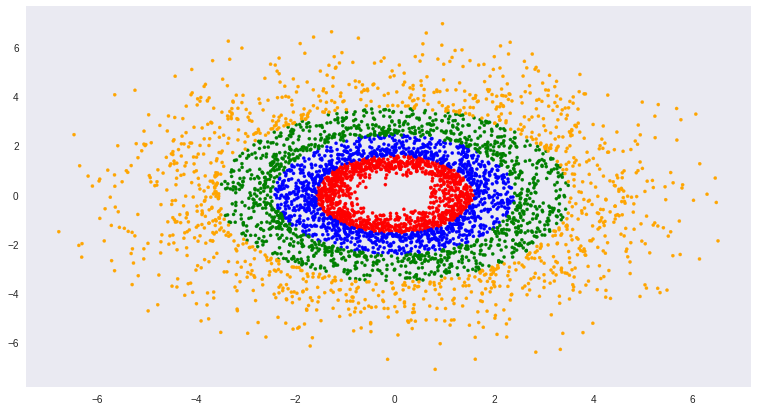

In [2]:
#2d data
n_samples = 5000
clusters = 4
theta = np.random.rand(n_samples)*2*np.pi
r = np.concatenate([np.random.rand(n_samples//clusters)*(i+1)*2//1.5+1.5 for i in range(clusters)])+\
    np.random.randn(n_samples)*0.3

data = np.array([r*np.cos(theta),r*np.sin(theta)]).T
dsort = np.argsort(data[:,0]**2+data[:,1]**2)

sne.set_style('dark')
plt.figure(figsize=(13,7))
plt.scatter(data[dsort,0],data[dsort,1],c=np.repeat(['red','blue','green','orange'],n_samples//clusters),s=10)
plt.show()

In [0]:
class VAE:
  pass

In [0]:
def declare_placeholders(self,n_features,n_clusters,hidden_layer_size):
  self.batch = tf.placeholder(tf.float32,[None,n_features])
  
VAE.__declare_placeholders = classmethod(declare_placeholders)

In [0]:
def cluster_encoder(self,n_clusters,hidden_layer_size):
  with tf.variable_scope('encoder'):
    self.ehidden = tf.layers.dense(self.batch,hidden_layer_size,tf.nn.relu,name='ehidden')
    self.ehidden2 = tf.layers.dense(self.ehidden,hidden_layer_size,tf.nn.relu,name='ehidden2')
    self.clusters = tf.layers.dense(self.ehidden2,n_clusters,tf.nn.softmax,name='clusters')
    self.clusters_for_inference = tf.expand_dims(self.clusters,1)*tf.ones([1,n_clusters,1])
    self.ehidden2_for_inference = tf.expand_dims(self.ehidden2,1)*tf.ones([1,n_clusters,1])
  
VAE.__cluster_encoder = classmethod(cluster_encoder)

In [0]:
def latent_encoder(self,n_clusters,n_features):
  with tf.variable_scope('encoder',reuse=tf.AUTO_REUSE):
    self.c_samples = tf.one_hot(tf.argmax(tf.log(self.clusters)-tf.log(-tf.log(tf.random_uniform(tf.shape(self.clusters)))),1),n_clusters)
    self.latent = tf.layers.dense(tf.concat([self.ehidden2,self.c_samples],1),2*n_features,name='latent')
    self.one_hots = tf.expand_dims(tf.eye(n_clusters),0)*tf.ones([tf.shape(self.batch)[0],1,1])
    self.latent_for_inference = tf.layers.dense(tf.concat([self.one_hots,self.ehidden2_for_inference],2),2*n_features,name='latent',reuse=True)
    self.l_samples_for_reconstruction = tf.random_normal(tf.shape(self.batch))*tf.exp(0.5*self.latent[:,n_features:])+self.latent[:,:n_features]
    self.l_samples_for_inference = tf.random_normal([tf.shape(self.batch)[0],n_clusters,n_features])*\
                                    tf.exp(0.5*self.latent_for_inference[:,:,n_features:])+self.latent_for_inference[:,:,:n_features]
    
VAE.__latent_encoder = classmethod(latent_encoder)

In [0]:
def decoder(self,hidden_layer_size,n_features):
  with tf.variable_scope('decoder',reuse=tf.AUTO_REUSE):
    self.dhidden = tf.layers.dense(tf.concat([self.l_samples_for_reconstruction,self.c_samples],1),hidden_layer_size,tf.nn.relu,name='dhidden')
    self.dhidden_for_inference = tf.layers.dense(tf.concat([self.one_hots,self.l_samples_for_inference],2),
                                                 hidden_layer_size,tf.nn.relu,name='dhidden',reuse=True)
    self.dhidden2 = tf.layers.dense(self.dhidden,hidden_layer_size,tf.nn.relu,name='dhidden2')
    self.dhidden2_for_inference = tf.layers.dense(self.dhidden_for_inference,hidden_layer_size,
                                                  tf.nn.relu,name='dhidden2',reuse=True)
    self.reconstruction = tf.layers.dense(self.dhidden2,n_features,name='reconstruction')
    self.reconstruction_for_inference = tf.layers.dense(self.dhidden2_for_inference,n_features,name='reconstruction',reuse=True)

VAE.__decoder = classmethod(decoder)

In [0]:
def losses(self,n_features,n_clusters,lr):
  with tf.variable_scope('losses'):
    self.categorical_kl = tf.reduce_mean(tf.reduce_sum(self.clusters*tf.log(n_clusters*self.clusters),1))
    self.kl_mixture = tf.reduce_mean(tf.reduce_sum(self.clusters*tf.reduce_sum(0.5*(tf.exp(self.latent_for_inference[:,:,n_features:]) +\
                                     tf.square(self.latent_for_inference[:,:,:n_features]) -\
                                     self.latent_for_inference[:,:,n_features:] - 1),2),1))
    self.reconstruction_loss = tf.reduce_mean(tf.reduce_sum(self.clusters*tf.reduce_sum(tf.squared_difference(tf.expand_dims(self.batch,1)*tf.ones([1,4,1]),
                                                     self.reconstruction_for_inference),2),1))
    self.loss = self.categorical_kl+self.kl_mixture+self.reconstruction_loss
    self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)
    
VAE.__losses = classmethod(losses)
                                    
                                    

In [0]:
def init(self,n_features,n_clusters,hidden_layer_size,lr=0.005):
  self.__declare_placeholders(n_features,n_clusters,hidden_layer_size)
  self.__cluster_encoder(n_clusters,hidden_layer_size)
  self.__latent_encoder(n_clusters,n_features)
  self.__decoder(hidden_layer_size,n_features)
  self.__losses(n_features,n_clusters,lr)
 
VAE.__init__ = classmethod(init)
  

In [0]:
def reconstruct(self,session,batch):
  return session.run(self.reconstruction,{self.batch:batch})

VAE.reconstruct = classmethod(reconstruct)

In [0]:
def mini_batch(observations,batch_size):
  batches = np.split(np.random.permutation(observations),np.arange(batch_size,observations,batch_size))
  for batch in batches:
    yield batch

1
51
101
151
201
251
301
351
401
451


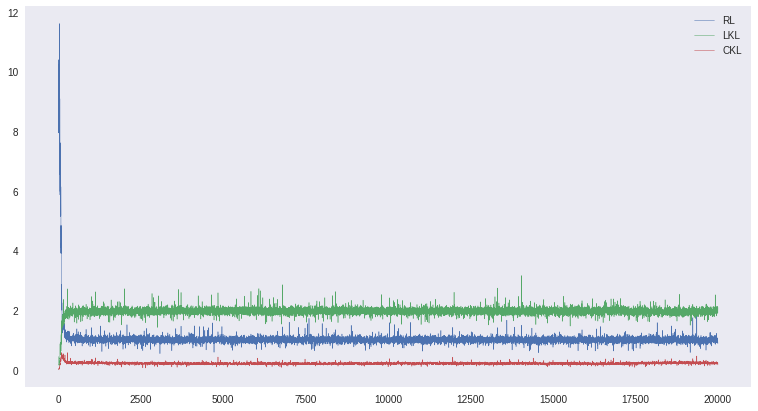

In [13]:
epochs = 500
batch_size = 128

tf.reset_default_graph()
sess = tf.Session()
vae = VAE(2,clusters,10,0.005)
sess.run(tf.global_variables_initializer())


mixture_kl = []
categorical_kl = []
rl = []

critic_steps = 100
for epoch in range(epochs):
  if epoch % 50 == 0:
    print(epoch+1)
  for batch in mini_batch(n_samples,batch_size):
    feed_dict = {vae.batch:data[batch]}
    sess.run(vae.train_op,feed_dict)
    r, l, c = sess.run([vae.reconstruction_loss,vae.kl_mixture,vae.categorical_kl],feed_dict)
    rl.append(r); mixture_kl.append(l); categorical_kl.append(c)
    
plt.figure(figsize=(13,7))
plt.plot(rl,lw=0.5,label='RL')
plt.plot(mixture_kl,lw=0.5,label='LKL')
plt.plot(categorical_kl,lw=0.5,label='CKL')
plt.legend()
plt.show()


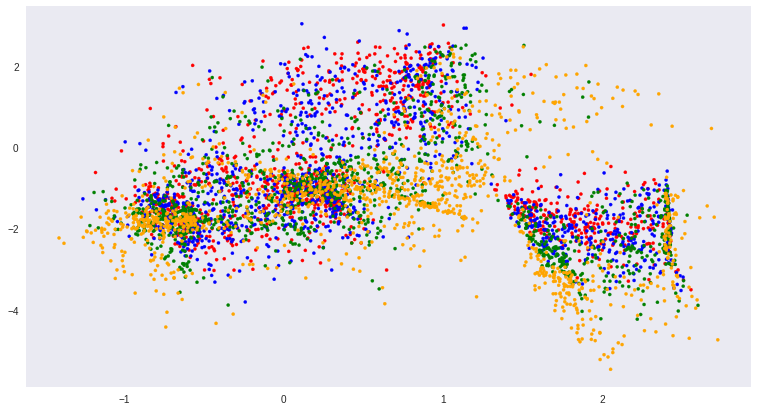

In [14]:
reconstruction = vae.reconstruct(sess,data)


plt.figure(figsize=(13,7))
plt.scatter(reconstruction[dsort,0],reconstruction[dsort,1],s=10,c=np.repeat(['red','blue','green','orange'],n_samples//clusters))
plt.show()